<a href="https://colab.research.google.com/github/andreamurari/chess_project_off/blob/main/chess_project_off.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn as skl
import statsmodels.api as sm

##**A) Data-set presentation**

This data-set groups data from more than 20,000 games collected from a selection of users on the site Lichess.org. This set contains:
*  Game ID;
*  Rated (Boolean value);
*  Start Time;
*  End Time;
*  Number of Turns;
*  Game Status;
*  Winner;
*  Time Increment;
*  White Player ID;
*  White Player Rating;
*  Black Player ID;
*  Black Player Rating;
*  All Moves in Standard Chess Notation;
*  Opening Eco (Standardised Code for any given opening, list here);
*  Opening Name;
*  Opening Ply (Number of moves in the opening phase);

In [ ]:
chess_df = pd.read_csv('/content/chess.csv')

In [ ]:
chess_df.head(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3


In [ ]:
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [ ]:
chess_df.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


***DATA HANDLING***

First it's generated a backup of the original data set:


In [ ]:
chess_df_backup = chess_df.copy()

Then all the columns that will not be used are dropped and two new columns are added:
* "white_win" : equals 1 if winner it's white player, 0 otherwise;
* "black_win" : equals 1 if winner it's black player, 0 otherwise.

In [ ]:
chess_df.drop(['moves', 'white_id', 'black_id', 'id', 'created_at', 'last_move_at', 'rated'], axis=1, inplace = True )

In [ ]:
chess_df['white_win'] = ( chess_df['winner'] == 'white' ) * 1

In [ ]:
chess_df['black_win'] = ( chess_df['winner'] == 'black' ) * 1

In [ ]:
chess_df.head(3)

,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply,white_win,black_win
0,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,5,1,0
1,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,0,1
2,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,3,1,0


***GENERAL CORRELATION***

Now it' ll be plotted a correlation graphs of the numerical variables in the data set.

In [ ]:
chess_corr = chess_df.corr()

<ipython-input-11-d72e7566516b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  chess_corr = chess_df.corr()


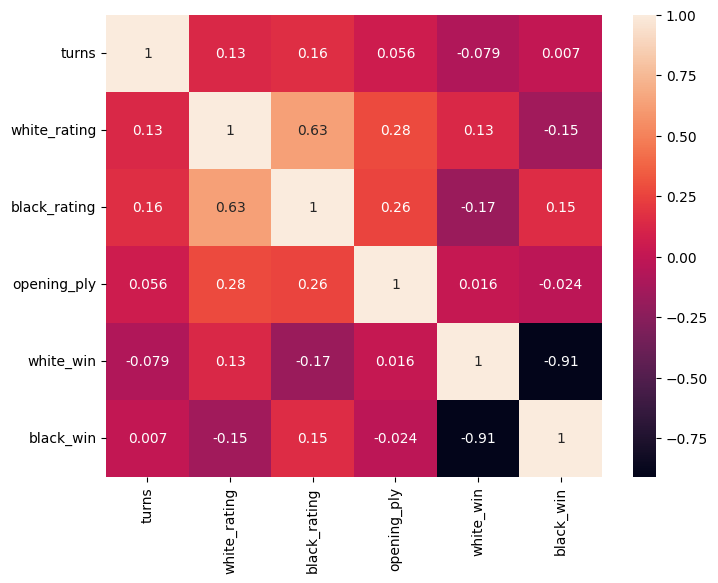

In [ ]:
plt.figure(figsize=(8, 6))
sb.heatmap(chess_corr, annot = True, )

plt.show()

As a first impression, the only parameters that seems to have a little correlation are:

* **white_rating and black_rating:** positive correlation, this is because matchmaking software matches opponents with similar ratings.
* **white_win and black_win:** negative correlation, obviously because if one player win, then the other loose. The correlation is not -1 because there can be some draws.

## **B) Which are the most common matches outcomes? What are the most played type of matches?**

***MOST COMMON MATCHES OUTCOMES***

In [ ]:
endgame_reason_df = chess_df['victory_status'].value_counts()

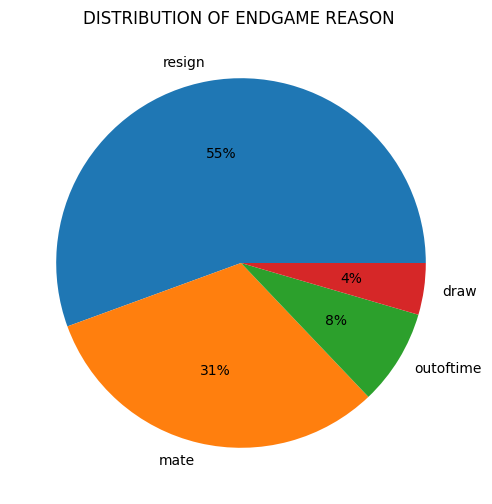

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(endgame_reason_df, labels = endgame_reason_df.index, autopct = '%i%%')
plt.title('DISTRIBUTION OF ENDGAME REASON ')

plt.show()

It's easy to see that the most endgame reason is "resign" followed by "checkmate". "Draws" and "out of time" are widely less frequent.

***MOST PLAYED TYPE OF MATCHES***

First, it's generated a boolean mask to exclude the least played match types ( <  2% of the total 20.000+ matches)

In [ ]:
most_played_mask = chess_df['increment_code'].value_counts() > chess_df['increment_code'].value_counts().sum() * 0.02

Then it's created a data frame of the most played type of matches so it can be plotted in a pie-chart. This DF groups match types played less than 2% of the total at the 'other' index.

In [ ]:
most_played_df = chess_df['increment_code'].value_counts()[most_played_mask]

In [ ]:
other = chess_df['increment_code'].value_counts().sum()- most_played_df.sum()
other_dict={'other':other}
other_series = pd.Series(other_dict)

In [ ]:
all_type_df = most_played_df.append(other_series, ignore_index= False)

<ipython-input-18-a4ae287d70ea>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_type_df = most_played_df.append(other_series, ignore_index= False)


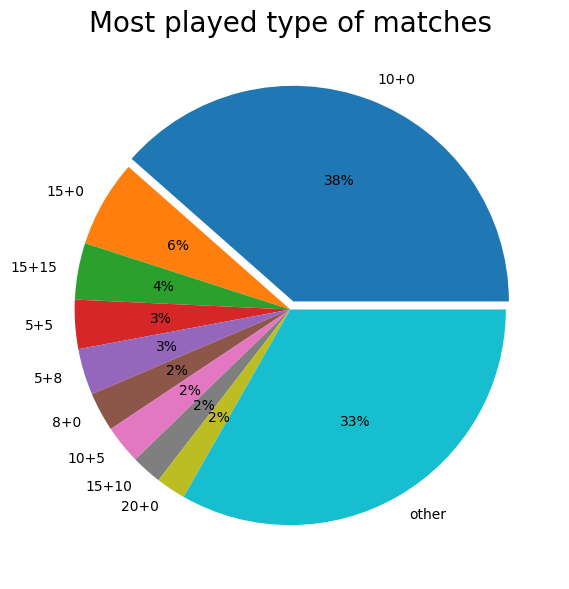

In [ ]:
plt.figure(figsize = (7,7))
explode = (0.04, 0, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(all_type_df, labels = all_type_df.index, explode = explode, autopct = '%i%%')
plt.title('Most played type of matches', fontdict={'fontsize':'20'})

plt.show()

It's higlited that the most frequently played match types are the 10+0. All other types are definitely less played.

## **C) Is there some correlation between starting with white pieces and the outcome of the match?**

This question can be answered plotting a bar-chart of the distribution of matches outcomes.

In [ ]:
winner_df = chess_df['winner'].value_counts()
winner_df

white    10001
black     9107
draw       950
Name: winner, dtype: int64

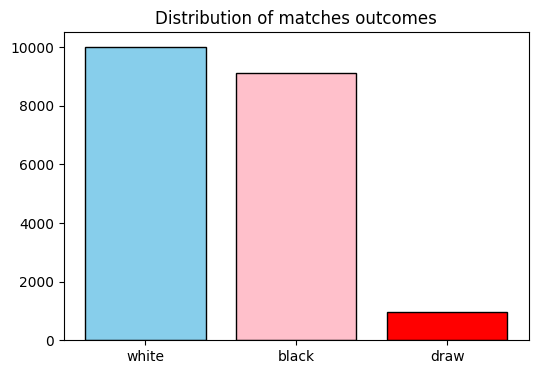

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(winner_df.index, winner_df, color = ('skyblue', 'pink', 'red'), edgecolor = 'black')
plt.title('Distribution of matches outcomes')

plt.show()

As we can see, white players have few more wins than black ones but the difference is very small:

In [ ]:
difference = chess_df['winner'].value_counts()['white']-chess_df['winner'].value_counts()['black']
difference

894

In [ ]:
difference_pct = int((chess_df['winner'].value_counts('pct')['white']-chess_df['winner'].value_counts('pct')['black'])*100)
print(difference_pct, '%')

4 %


only 894 matches (4%).